# 深度学习 实验3

本节课我们实现包含隐层的神经网络模型，并在手写数字识别数据集上进行测试。

## 数据集

手写数字识别数据集

下载链接：https://www.kaggle.com/c/digit-recognizer/data

（本节课仅需要训练集）

## 代码说明

下面的代码构造了一个包含隐层的神经网络模型，模型分为输入层、隐含层、输出层

输入层包含 $784$ 个神经元，输入手写数字的灰度向量，输出 $U$
$$
U=X
$$

隐含层包含 $30$ 个神经元，输入 $U$，输出 $V$
$$
V=\sigma(W_1U)
$$

输出层包含 $10$ 个神经元，输入 $V$，输出 $\hat Y$ 表示每个数字的概率
$$
\hat Y=\sigma(W_2V)
$$

其中 $\sigma$ 表示 Sigmoid 函数，每个样本数据都以列向量进行存储和计算，损失函数取所有样本预测值的均方误差

$$
Loss=\frac{1}{N}\sum_{i=1}^N (\hat Y_i-Y_i)^2
$$

但是，这个模型的效率太低了，请做出适当修改（**或删了重写**），以提高训练效率和准确率。

## 可选的修改方式

### 1. 向模型中添加阈值

$$
U=X+B_0
$$
$$
V=\sigma(W_1U+B_1)
$$
$$
\hat Y=\sigma(W_2V+B_2)
$$

### 2. 改为随机梯度下降

代码中每次迭代会计算所有样本的均方误差，这是极其低效的，可以修改为每次取一批样本（例如128个）计算损失和梯度并更新参数。

### 3. 修改激活函数与损失函数

手写数字识别分类问题本质是多分类问题，对于多分类问题，一个常用的组合是 Softmax 函数与交叉熵损失，这可以提高模型的收敛速度。

### 4. 使用高效的优化算法

随机梯度下降法固然是一个高效的优化算法，但也可选择更高效的优化算法，例如 Adam 算法。

### 5. 调参

A：这就是你的深度学习系统？

B：是呀！你把数据倒进这一大堆线性代数里，再到另一边等着答案出来。

A：如果答案是错的呢？

B：那就拿根棍子搅一搅这堆东西，一直搅到答案正确未为止。

![](https://i.loli.net/2021/03/29/dTsolpvPxk92YXe.jpg)

实现了用adam算法更新学习率并且使用了网上推荐的参数值，但是发现用SGD作为更新学习率的算法更加高效，准确率更高，所以底下放了两个代码

第一个代码是用SGD作为学习方法，第二个使用Adam算法作为学习方法

以下两个代码都作了如下改进：增加截距项B，输出层使用了softmax函数以及交叉熵损失函数，实现了小批次随机梯度。准确率已经可以高达99.9%

0.1328125
0.859375
0.8984375
0.90625
0.9375
0.8984375
0.9375
0.9609375
0.96875
0.9140625
0.984375
0.96875
0.953125
0.9609375
0.953125
0.953125
0.9609375
0.9765625
0.9609375
0.96875
0.953125
0.96875
0.96875
0.984375
0.9609375
0.96875
0.9765625
0.9609375
0.9609375
0.9765625
0.9765625
0.9765625
0.9765625
0.9921875
0.96875
0.9921875
0.96875
0.9453125
0.9609375
0.9609375
0.9765625
0.984375
1.0
0.9921875
0.984375
0.9921875
0.953125
0.984375
0.96875
0.9921875
0.9921875
0.9921875
0.9765625
0.9609375
0.9921875
0.9765625
0.9765625
0.984375
0.96875
0.9921875
0.9609375
0.96875
1.0
1.0
0.9765625
0.9921875
0.9765625
0.9765625
0.9765625
0.9921875
0.9765625
0.9921875
0.96875
0.9921875
0.9765625
0.9921875
0.9921875
1.0
0.9921875
1.0
0.984375
1.0
0.984375
1.0
0.984375
0.9921875
1.0
0.984375
0.984375
0.9921875
0.9609375
0.9921875
0.9921875
0.9921875
1.0
0.984375
1.0
0.9921875
0.984375
1.0


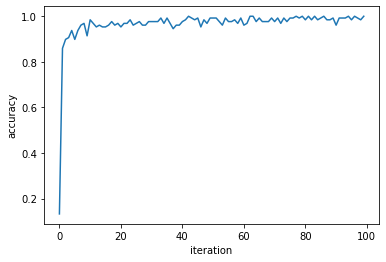

In [1]:
import pandas as pd
import numpy as np
from random import *
import matplotlib.pyplot as plt


# 从 DataFrame 中读取x与y，转化为 numpy 数组
def get_x_y(data):
    x = data[[i for i in list(data.columns) if i != "label"]].values
    # 将标签转化为 one-hot 向量
    y_list = []
    for i in data["label"]:
        y = [0] * 10
        y[i] = 1
        y_list.append(y)
    return np.array(x) / 255, np.array(y_list)


# 计算准确率
def accuracy(y_pred, y_true):
    ac = 0
    for i in range(y_true.shape[1]):
        # 计算预测的标签
        temp = [y_pred[j][i] for j in range(10)]
        label_pred = temp.index(max(temp))
        # 计算真实的标签
        temp = [y_true[j][i] for j in range(10)]
        label_true = temp.index(max(temp))
        if label_pred == label_true:
            ac += 1
    return ac / y_true.shape[1]


# 神经网络的层（啥都不做的层）
class DenseLayer:
    def __init__(self, n):
        self.n = n

    def connect(self, layer):
        pass

    def forward(self, x):
        return x

    def backward(self, dy):
        return dy


# 神经网络的层（全连接层）
class LinearLayer:
    # 初始化
    def __init__(self, n, activation, activation_diff):
        # 神经元个数
        self.n = n
        # 激活函数
        self.activation = activation
        # 激活函数导数
        self.activation_diff = activation_diff
        # 学习率
        self.eta = 0.01

    # 全连接，随机初始化 w，一个self.nxlayer.n的矩阵
    def connect(self, layer):
        self.w = np.random.rand(self.n, layer.n + 1) * 0.2 - 0.1

    # 前向传播
    def forward(self, x):
        self.x = x
        self.u = np.matmul(self.w, self.x)  # u=w*x
        self.y = self.activation(self.u)  # y=sigmoid(wx)
        return self.y


    # 反向传播 传入损失函数对该层每个输出值的导数，传出损失函数对该层每个输入值的导数
    def backward(self, dy, update=True):
        self.du = dy * self.activation_diff(self.u)  # (y-sigmoid(wx+b))xsigmoid'(wx+b)--{10x128}*{10x128}={10*128}
        self.dw = np.matmul(self.du, self.x.T)  # {10x31}

        self.w_nb = np.delete(self.w, self.w.shape[1] - 1, axis=1)

        self.dx = np.matmul(self.w_nb.T, self.du)
        if update:
            self.w -= self.eta * self.dw  # {10x31}
        return self.dx


# sigmoid 激活函数 f(x)=1/(1+exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# sigmoid 激活函数的导数 f'(x)=f(x)(1-f(x))
def sigmoid_diff(x):
    return sigmoid(x) * (1 - sigmoid(x))


def softmax(x):
    x=x.T
    X=[]
    for r in x:
        e_x = np.exp(r - np.max(r))
        X.append(e_x / e_x.sum())
    X=np.array(X)
    return X.T
def softmax_diff(x):
    return 1;
# 读取训练数据 标签y以onehot编码存储
train_data = pd.read_csv("train.csv")
train_x, train_y = get_x_y(train_data)
# 转置一下，每个样本数据以列向量进行存储和计算
train_x = train_x.T  # 784x42000
ones = [1 for _ in range(42000)]
train_x = np.vstack((train_x, ones))
train_y = train_y.T  # 变成列向量,10x42000

# 构造神经网络
input_layer = DenseLayer(784)
hidden_layer = LinearLayer(30, sigmoid, sigmoid_diff)
hidden_layer.connect(input_layer)
output_layer = LinearLayer(10, softmax, softmax_diff)
#output_layer = LinearLayer(10, sigmoid, sigmoid_diff)
output_layer.connect(hidden_layer)

ac = []
for iteration in range(10000):
    # 正向传播
    index = sample([i for i in range(42000)], 128)
    x = train_x[:, index]
    y1 = train_y[:, index]
    u = input_layer.forward(x)  # u={785x128}
    v = hidden_layer.forward(u)  # v={30x785}{785x128}={30x128}
    ones = [1 for _ in range(128)]
    v = np.vstack((v, ones))  # {31x128}

    # 使用softmax函数
    y = output_layer.forward(v)  # y={10x31}{31x128}={10x128}
    # 计算损失函数对每个输出值的导数
    #d_loss = (y - y1) / y.shape[1]
    d_loss = (y - y1)
    # 反向传播
    dv = output_layer.backward(d_loss)
    du = hidden_layer.backward(dv)
    # 输出准确率
    if iteration % 100 == 0:
        print(accuracy(y, y1))
        ac.append(accuracy(y, y1))




plt.plot([i for i in range(100)], ac)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()


0.109375
0.3359375
0.5703125
0.7890625
0.8984375
0.8046875
0.9140625
0.875
0.9140625
0.921875
0.859375
0.8828125
0.8984375
0.8828125
0.8515625
0.921875
0.9609375
0.9296875
0.9296875
0.8984375
0.9375
0.875
0.9453125
0.953125
0.96875
0.8984375
0.953125
0.9296875
0.9375
0.9453125
0.9609375
0.9375
0.96875
0.953125
0.96875
0.9609375
0.96875
0.9296875
0.9453125
0.9453125
0.9453125
0.9609375
0.9609375
0.9609375
0.9296875
0.90625
0.921875
0.9453125
0.9375
0.953125
0.9453125
0.9609375
0.9453125
0.9609375
0.953125
0.9921875
0.9609375
0.9296875
0.9609375
0.96875
0.9765625
0.953125
0.9609375
0.96875
0.96875
0.9609375
0.9609375
0.9921875
0.9921875
0.9609375
0.96875
0.984375
0.9609375
0.96875
0.9609375
0.9921875
0.953125
0.984375
0.9765625
0.9453125
0.9609375
0.9609375
0.984375
0.9765625
0.9453125
0.96875
0.984375
0.9765625
0.9453125
0.9921875
0.953125
0.953125
0.96875
0.9765625
0.9609375
0.984375
0.9765625
0.9765625
0.9765625
0.9765625


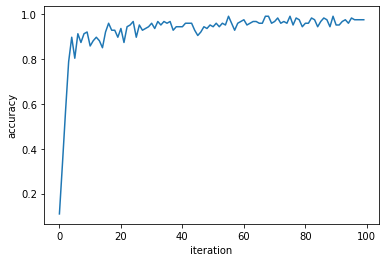

In [2]:
import pandas as pd
import numpy as np
from random import *
import matplotlib.pyplot as plt


# 从 DataFrame 中读取x与y，转化为 numpy 数组
def get_x_y(data):
    x = data[[i for i in list(data.columns) if i != "label"]].values
    # 将标签转化为 one-hot 向量
    y_list = []
    for i in data["label"]:
        y = [0] * 10
        y[i] = 1
        y_list.append(y)
    return np.array(x) / 255, np.array(y_list)


# 计算准确率
def accuracy(y_pred, y_true):
    ac = 0
    for i in range(y_true.shape[1]):
        # 计算预测的标签
        temp = [y_pred[j][i] for j in range(10)]
        label_pred = temp.index(max(temp))
        # 计算真实的标签
        temp = [y_true[j][i] for j in range(10)]
        label_true = temp.index(max(temp))
        if label_pred == label_true:
            ac += 1
    return ac / y_true.shape[1]


# 神经网络的层（啥都不做的层）
class DenseLayer:
    def __init__(self, n):
        self.n = n

    def connect(self, layer):
        pass

    def forward(self, x):
        return x

    def backward(self, dy):
        return dy


# 神经网络的层（全连接层）
class LinearLayer:
    # 初始化
    def __init__(self, n, activation, activation_diff):
        # 神经元个数
        self.n = n
        # 激活函数
        self.activation = activation
        # 激活函数导数
        self.activation_diff = activation_diff
        # 学习率
        self.eta = 0.001


        self.v=0
        self.beta1=0.9
        self.beta2=0.999
        self.eps=1e-8


    # 全连接，随机初始化 w，一个self.nxlayer.n的矩阵
    def connect(self, layer):
        self.w = np.random.rand(self.n, layer.n + 1) * 0.2 - 0.1
        self.m = np.ones((self.n,layer.n+1))
        self.v = np.ones((self.n,layer.n+1))
    # 前向传播
    def forward(self, x):
        self.x = x
        self.u = np.matmul(self.w, self.x)  # u=w*x
        self.y = self.activation(self.u)  # y=sigmoid(wx)
        return self.y


    # 反向传播 传入损失函数对该层每个输出值的导数，传出损失函数对该层每个输入值的导数
    def backward(self, dy, update=True):
        self.du = dy * self.activation_diff(self.u)  # (y-sigmoid(wx+b))xsigmoid'(wx+b)--{10x128}*{10x128}={10*128}
        self.dw = np.matmul(self.du, self.x.T)  # {10x31}
        self.w_nb = np.delete(self.w, self.w.shape[1] - 1, axis=1)

        self.dx = np.matmul(self.w_nb.T, self.du)
        if update:
            self.m=self.beta1*self.m + (1-self.beta1)*self.dw
            self.v = self.beta2 * self.v + (1 - self.beta2) * (self.dw ** 2)
            self.w -= self.eta * self.m/ (np.sqrt(self.v) + self.eps) # {10x31}
        return self.dx


# sigmoid 激活函数 f(x)=1/(1+exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# sigmoid 激活函数的导数 f'(x)=f(x)(1-f(x))
def sigmoid_diff(x):
    return sigmoid(x) * (1 - sigmoid(x))


def softmax(x):
    x=x.T
    X=[]
    for r in x:
        e_x = np.exp(r - np.max(r))
        X.append(e_x / e_x.sum())
    X=np.array(X)
    return X.T
def softmax_diff(x):
    return 1;
# 读取训练数据 标签y以onehot编码存储
train_data = pd.read_csv("train.csv")
train_x, train_y = get_x_y(train_data)
# 转置一下，每个样本数据以列向量进行存储和计算
train_x = train_x.T  # 784x42000
ones = [1 for _ in range(42000)]
train_x = np.vstack((train_x, ones))
train_y = train_y.T  # 变成列向量,10x42000

# 构造神经网络
input_layer = DenseLayer(784)
hidden_layer = LinearLayer(30, sigmoid, sigmoid_diff)
hidden_layer.connect(input_layer)
output_layer = LinearLayer(10, softmax, softmax_diff)
#output_layer = LinearLayer(10, sigmoid, sigmoid_diff)
output_layer.connect(hidden_layer)

ac = []
for iteration in range(10000):
    # 正向传播
    index = sample([i for i in range(42000)], 128)
    x = train_x[:, index]
    y1 = train_y[:, index]
    u = input_layer.forward(x)  # u={785x128}
    v = hidden_layer.forward(u)  # v={30x785}{785x128}={30x128}
    ones = [1 for _ in range(128)]
    v = np.vstack((v, ones))  # {31x128}

    # 使用softmax函数
    y = output_layer.forward(v)  # y={10x31}{31x128}={10x128}
    # 计算损失函数对每个输出值的导数
    #d_loss = (y - y1) / y.shape[1]
    d_loss = (y - y1)
    # 反向传播
    dv = output_layer.backward(d_loss)
    du = hidden_layer.backward(dv)
    # 输出准确率
    if iteration % 100 == 0:
        print(accuracy(y, y1))
        ac.append(accuracy(y, y1))




plt.plot([i for i in range(100)], ac)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()